In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
from datetime import datetime as dt
import math as m

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
def get_data(query):
    import config
    config=config.config_sqlserver()
    conn = pyodbc.connect(*config)

    c=conn.cursor()
    c.execute(query)
    data=c.fetchall()
    conn.close()
    return data

In [3]:
ticker_list = get_data("Select distinct ticker from us_stage1")
stock_list = []
for l in ticker_list:
    stock_list.append(l[0])

In [4]:
#Create data frame
#Use three stocks to save time
import config
config=config.config_sqlserver()
conn = pyodbc.connect(*config)

#stock_list = ['AAPL','GOOG','AMZN']
for stock in stock_list:
    sql = "SELECT * from us_stage1 where ticker= '%s'" % stock
    globals()[stock] = pd.read_sql(sql, conn)
conn.close()

In [5]:
#Another way to calculate Moving Average  
def MA(df, n):  
    name = 'MA ' + str(n) + ' Days'
    df[name] = pd.Series.rolling(df['adj_close'], n).mean() 
    return df

In [6]:
#Commodity Channel Index  
def CCI(df, n):  
    PP = (df['high'] + df['low'] + df['adj_close']) / 3  
    name = 'CCI_' + str(n)
    df[name] = pd.Series((PP - pd.Series.rolling(PP, n).mean()) / (0.015*pd.Series.rolling(PP, n).std()))  
#    df = df.join(CCI)  
    return df

## Compute the Commodity Channel Index(CCI) for google based on the 20-day Moving average
#n = 10
#GOOG_CCI = CCI(GOOG, n)

In [7]:
# Compute the Bollinger Bands 
def BBANDS(df, ndays):
    MA = pd.Series.rolling(df['close'], ndays).mean()
    SD = pd.Series.rolling(df['close'], ndays).std()
    
    b1 = MA + (2 * SD)
    name1 = 'Upper BollingerBand'
    df[name1] = pd.Series(b1)
    
    b2 = MA - (2 * SD)
    name2 = 'Lower BollingerBand'
    df[name2] = pd.Series(b2)
    
    return df

## Compute the Bollinger Bands for NIFTY using the 50-day Moving average
#n = 50
#GOOG_BBANDS = BBANDS(GOOG, n)
#GOOG_BBANDS[50:]

In [8]:
for stock in stock_list:
    stock_df = globals()[stock]
    stock_df = MA(stock_df, 5)
    stock_df = MA(stock_df, 10)
    stock_df = MA(stock_df, 20)
    stock_df = MA(stock_df, 30)
    stock_df = CCI(stock_df, 20)
    stock_df = BBANDS(stock_df, 30)

In [9]:
def model1(ma1=5,ma2=10,ma3=20,ma4=30,cci_n=20,bband_n=30):
    for stock in stock_list:
        stock_df = globals()[stock]
        stock_df = MA(stock_df, ma1)
        stock_df = MA(stock_df, ma2)
        stock_df = MA(stock_df, ma3)
        stock_df = MA(stock_df, ma4)
        stock_df = CCI(stock_df, cci_n)
        stock_df = BBANDS(stock_df, bband_n)
        name1='MA '+ str(ma1) +' Days'
        p1 = stock_df[name1][ma1-1]
        name2='MA '+ str(ma2) +' Days'
        p2 = stock_df[name2][ma2-1]
        name3='MA '+ str(ma3) +' Days'
        p3 = stock_df[name3][ma3-1]
        name4='MA '+ str(ma4) +' Days'
        p4 = stock_df[name4][ma4-1]
        name_cci = 'CCI_' + str(cci_n)
        p_cci = stock_df[name_cci][cci_n-1]
        p_bband_upper = stock_df['Upper BollingerBand'][bband_n-1]
        p_bband_lower = stock_df['Lower BollingerBand'][bband_n-1]
        if ((p1>p2)&(p2>p3)&(p3>p4)) & (p_cci>=100) & (stock_df['adj_close'][0] >= p_bband_upper):
            print(stock + ' is ready for long in Model 1!')
        elif ((p1<p2)&(p2<p3)&(p3<p4)) & (p_cci<=-100) & (stock_df['adj_close'][0] <= p_bband_lower):
            print(stock + ' is ready for short in Model 1!')
        else:
            pass
    print('Done')

In [10]:
model1()

FULL is ready for short in Model 1!
CDZI is ready for long in Model 1!
Done


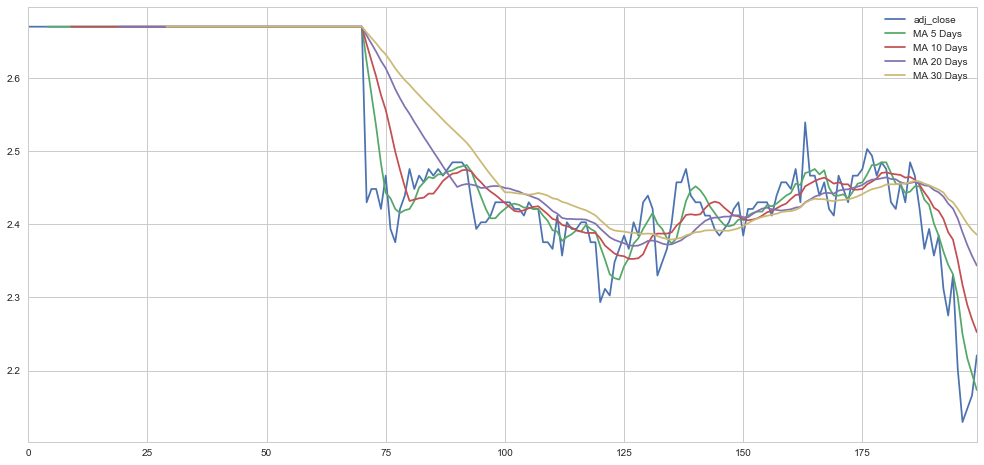

In [18]:
FULL[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][:200].plot(figsize=(17,8))

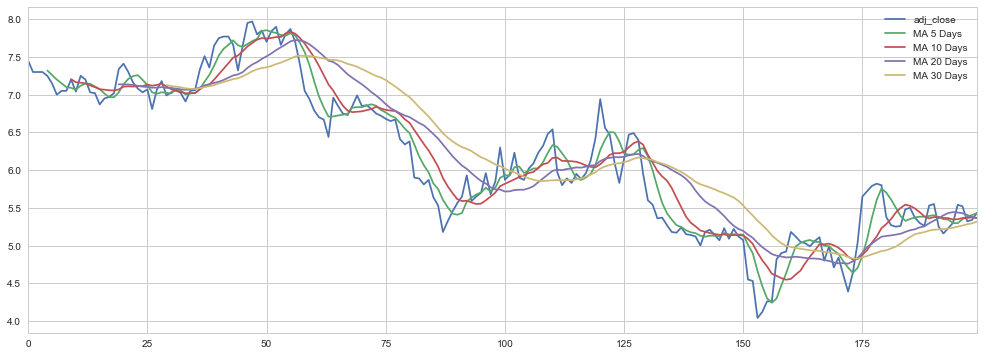

In [17]:
CDZI[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][:200].plot(figsize=(17,6))

In [ ]:
###These are another solutions
#ma_day = [5, 10,20,30]
#for stock in stock_list:
#    for ma in ma_day:
#        colums_name='MA %s Days' % (str(ma))
#        stock_col = globals()[stock]
#        stock_col[colums_name] = Series.rolling(stock_col['adj_close'],ma).mean()

#GOOG_Sub = GOOG[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][(GOOG['date']>=dt(2016,2,1).date())]
#GOOG_Sub[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']].plot(figsize=(10,4))
#AAPL[['adj_close','MA 5 Days','MA 10 Days','MA 20 Days','MA 30 Days']][(AAPL['date']>=dt(2016,2,1).date())].plot(figsize=(10,4))